# Importing the libraries

In [70]:
import cv2
import numpy as np
import tensorflow as tf
from sklearn import preprocessing, model_selection
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import regularizers, optimizers
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Loading and Preprocessing the data

In [10]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [11]:
x_val, x_test, y_val, y_test = model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [29]:
winSize = (28,28)
blockSize = (28,28)
blockStride = (2,2)
cellSize = (4,4)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 0
nlevels = 64
signedGradients = True

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,
cellSize,nbins,derivAperture,
winSigma,histogramNormType,L2HysThreshold,
gammaCorrection,nlevels, signedGradients)


In [30]:
x_train_hog = np.array([hog.compute(x_train[0])])
x_test_hog = np.array([hog.compute(x_test[0])])
x_val_hog = np.array([hog.compute(x_val[0])])
for i in range(x_train.shape[0]-1):
    descriptor = hog.compute(x_train[i+1])
    x_train_hog = np.append(x_train_hog, np.array([descriptor]), axis=0)
for i in range(x_test.shape[0]-1):
    descriptor2 = hog.compute(x_test[i+1])
    x_test_hog = np.append(x_test_hog, np.array([descriptor2]), axis=0)
for i in range(x_val.shape[0]-1):
    descriptor3 = hog.compute(x_val[i+1])
    x_val_hog = np.append(x_val_hog, np.array([descriptor3]), axis=0)

sc = StandardScaler()
x_train_hog = sc.fit_transform(x_train_hog)
x_test_hog = sc.transform(x_test_hog)
x_val_hog = sc.transform(x_val_hog)

In [31]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Implementing the model and training it

In [105]:
model = tf.keras.models.Sequential()
model.add(Dense(units=32*4, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

In [106]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [107]:
model.compile(Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

In [108]:
history = model.fit(x_train_hog, y_train, batch_size = 64, epochs = 50, validation_data=(x_val_hog, y_val))

Epoch 1/50
938/938 [==============================] - 4s 4ms/step - loss: 0.3860 - accuracy: 0.8677 - val_loss: 0.3057 - val_accuracy: 0.8922
Epoch 2/50
938/938 [==============================] - 4s 4ms/step - loss: 0.2689 - accuracy: 0.9051 - val_loss: 0.2742 - val_accuracy: 0.9012
Epoch 3/50
938/938 [==============================] - 4s 4ms/step - loss: 0.2364 - accuracy: 0.9168 - val_loss: 0.2534 - val_accuracy: 0.9120
Epoch 4/50
938/938 [==============================] - 4s 4ms/step - loss: 0.2132 - accuracy: 0.9252 - val_loss: 0.2539 - val_accuracy: 0.9092
Epoch 5/50
938/938 [==============================] - 4s 4ms/step - loss: 0.1969 - accuracy: 0.9312 - val_loss: 0.2569 - val_accuracy: 0.9122
Epoch 6/50
938/938 [==============================] - 4s 4ms/step - loss: 0.1828 - accuracy: 0.9351 - val_loss: 0.2555 - val_accuracy: 0.9106
Epoch 7/50
938/938 [==============================] - 4s 4ms/step - loss: 0.1697 - accuracy: 0.9413 - val_loss: 0.2518 - val_accuracy: 0.9164
Epoch 

# Evaluation

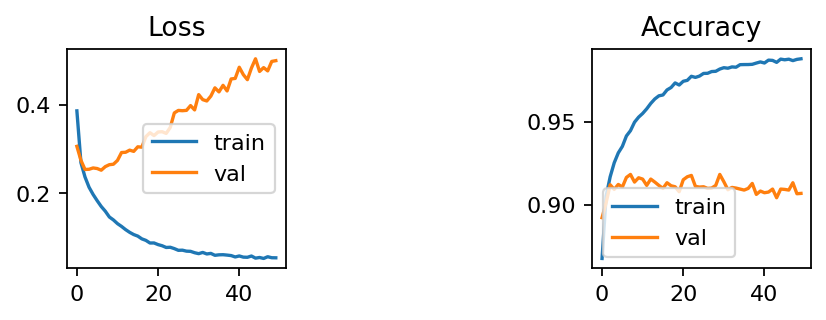

In [109]:
plt.figure(dpi=160)

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [110]:
y_hat = model.predict(x_test_hog)

157/157 [==============================] - 0s 2ms/step


In [111]:
y_hat[y_hat>=0.5] = 1
y_hat[y_hat<0.5] = 0


For Test Set
F1 score:  0.9077246768860837
Accuracy:  0.906
Precision:  0.909455932543666
Recall:  0.906
Confusion Matrix: 



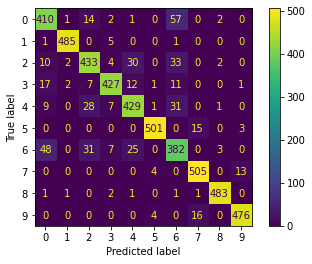

In [112]:
print('\nFor Test Set')
f1 = f1_score(y_test, y_hat, average='micro')
print('F1 score: ' , f1)

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: ' , accuracy)

precision = precision_score(y_test, y_hat, average='micro')
print('Precision: ' , precision)

recall = recall_score(y_test, y_hat, average='micro')
print('Recall: ' , recall)

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis=1), y_hat.argmax(axis=1)))
print('Confusion Matrix: \n')
matrix.plot()
plt.show()